In [1]:
# Load your data
import pandas as pd

expression_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

data = pd.read_csv(expression_file, sep="\t")
tg = data.iloc[:,0:100]

tg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.26,7.52,3.05,5.29,8.00,4.02,3.99,3.89,6.73,3.71,...,7.33,8.11,7.60,4.43,6.23,4.70,4.85,5.48,3.33,3.530
1,7.72,9.75,3.25,3.18,4.19,6.19,4.68,2.57,6.26,4.79,...,3.93,6.77,2.27,7.52,7.17,5.92,7.69,6.64,5.46,6.160
2,1.31,4.23,2.43,3.72,5.78,2.55,6.59,1.76,9.21,4.24,...,6.04,8.59,7.01,6.51,3.15,1.93,4.82,6.87,4.63,0.816
3,6.87,5.70,2.42,3.76,4.91,6.83,3.98,2.37,3.81,3.33,...,3.97,3.12,6.96,6.22,5.06,4.95,5.84,3.25,2.56,6.930
4,2.33,5.48,2.56,3.06,2.11,5.91,5.34,3.62,5.14,1.55,...,4.11,5.38,6.47,8.18,5.61,5.22,9.52,5.88,6.19,3.290


In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  
    tg_expression = data.iloc[:, 100:].values  
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None)
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn(models, threshold=0.030993328562239107):
    grn_edges = []
    for i, model in enumerate(models):
        importance = model.feature_importances_
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
      
    return grn_edges

def evaluate_grn(predicted_edges, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    ground_truth.head()
    ground_truth_set = set(tuple(x) for x in ground_truth.values)
    predicted_set = set(predicted_edges) #convert into a set to get the unique ordered pairs (also can't edit the sets themselves)
    
   
    #Accuracy (tn calcuation) doesn't seem to be meaningful because there will be more non-regulatory edges then actual edges
    
    tp = len(predicted_set & ground_truth_set)
    fp = len(predicted_set - ground_truth_set)
    fn = len(ground_truth_set - predicted_set)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("HERE ARE TP,FP,FN")  
    print(tp,fp,fn)
    return precision, recall


# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Infer the gene regulatory network
predicted_grn_edges = infer_grn(models)


# Evaluate the GRN
precision, recall= evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

HERE ARE TP,FP,FN
271 97 216
Precision: 0.7364130434782609, Recall: 0.5564681724845996


In [4]:
def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as the score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression


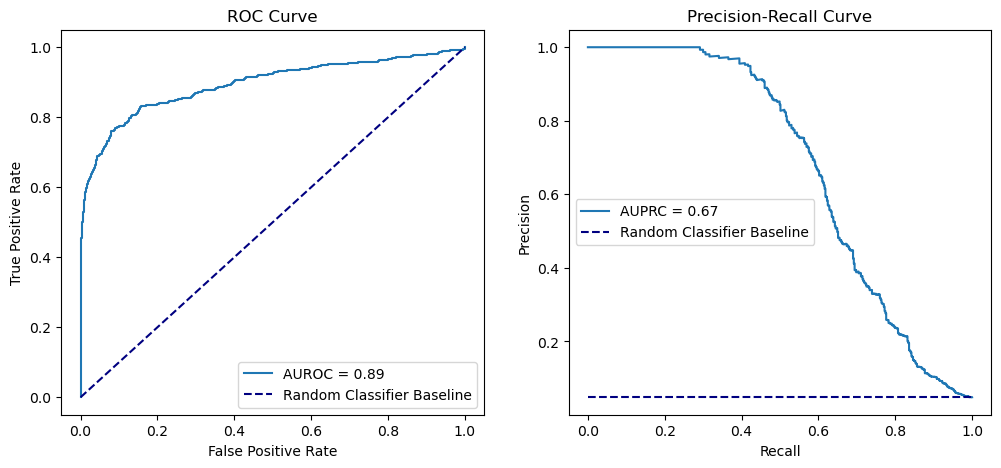

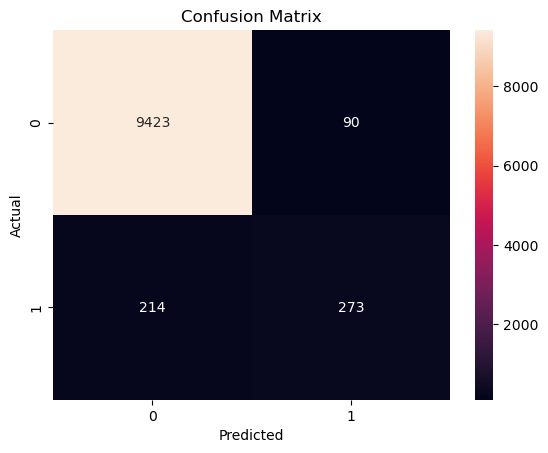

AUROC: 0.8937409976750718, AUPRC: 0.6703348650591965, Max F1 Score: 0.6439482961222092, Best Threshold: 0.030993328562239107


In [6]:
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")


Correlation Pruning 

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor

def correlation_pruning(preliminary_network, expression_data, threshold):
    pruned_network = []
    for tf, tg in preliminary_network:
        correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg])  # tg is already referenced from indices 100 onward
        if abs(correlation) > threshold:
            pruned_network.append((tf, tg))
    return pruned_network

expression_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

# Assume the rest of the functions like train_models and load_data are defined as above
expression_data = pd.read_csv(expression_file, sep="\t", header=None).values

# Load your data
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene and construct preliminary network
models = train_models(tf_expression, tg_expression)
preliminary_network = infer_grn(models)  # Modify this function to output (tf, tg) pairs

# Prune the network based on correlation
final_network = correlation_pruning(preliminary_network, expression_data,threshold=0.2)

# Evaluate the final GRN
precision, recall = evaluate_grn(final_network, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

HERE ARE TP,FP,FN
361 1155 126
Precision: 0.23812664907651715, Recall: 0.7412731006160165


Shap

In [8]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor

def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

def infer_grn_with_shap(models, shap_values_list, threshold):
    grn_edges = []
    for i, (model, shap_values) in enumerate(zip(models, shap_values_list)):
        # Use mean absolute SHAP values as feature importance
        importance = np.abs(shap_values).mean(axis=0) #compute mean shaps values
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
    return grn_edges

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Infer the gene regulatory network using SHAP values
predicted_grn_edges = infer_grn_with_shap(models, shap_values_list,threshold=0.02)

# Evaluate the GRN
precision, recall = evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


HERE ARE TP,FP,FN
412 1570 75
Precision: 0.20787083753784055, Recall: 0.8459958932238193


PRC for Shap Model

HERE ARE TP,FP,FN
449 4190 38
HERE ARE TP,FP,FN
411 1566 76
HERE ARE TP,FP,FN
372 778 115
HERE ARE TP,FP,FN
346 426 141
HERE ARE TP,FP,FN
324 288 163
HERE ARE TP,FP,FN
305 195 182
HERE ARE TP,FP,FN
292 141 195
HERE ARE TP,FP,FN
281 106 206
HERE ARE TP,FP,FN
274 79 213
HERE ARE TP,FP,FN
267 57 220
HERE ARE TP,FP,FN
255 43 232
HERE ARE TP,FP,FN
242 36 245
HERE ARE TP,FP,FN
239 29 248
HERE ARE TP,FP,FN
234 21 253
HERE ARE TP,FP,FN
221 18 266
HERE ARE TP,FP,FN
210 14 277
HERE ARE TP,FP,FN
203 12 284
HERE ARE TP,FP,FN
193 11 294
HERE ARE TP,FP,FN
190 11 297
HERE ARE TP,FP,FN
185 8 302
HERE ARE TP,FP,FN
178 6 309
HERE ARE TP,FP,FN
174 6 313
HERE ARE TP,FP,FN
170 4 317
HERE ARE TP,FP,FN
165 4 322
HERE ARE TP,FP,FN
158 2 329
HERE ARE TP,FP,FN
154 1 333
HERE ARE TP,FP,FN
149 1 338
HERE ARE TP,FP,FN
146 0 341
HERE ARE TP,FP,FN
142 0 345
HERE ARE TP,FP,FN
139 0 348
HERE ARE TP,FP,FN
133 0 354
HERE ARE TP,FP,FN
129 0 358
HERE ARE TP,FP,FN
127 0 360
HERE ARE TP,FP,FN
121 0 366
HERE ARE TP,FP,FN
117

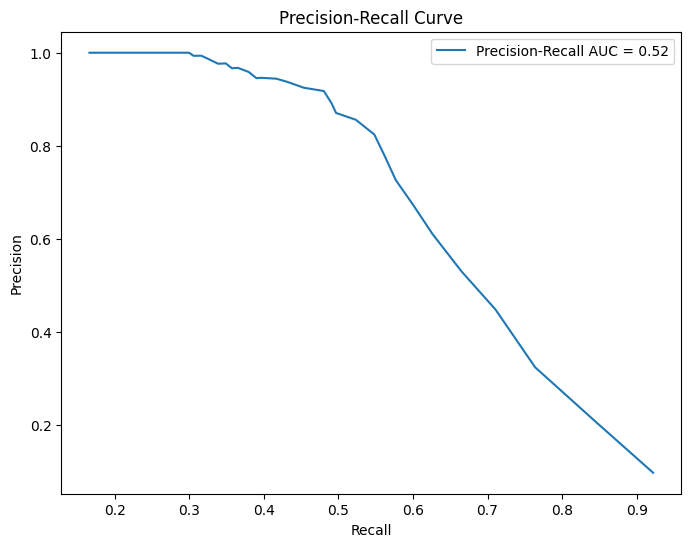

In [40]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assume you have the following functions defined:
# load_data, train_models_with_shap, infer_grn_with_shap, evaluate_grn

# Load your data
tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Vary the threshold values
threshold_values = np.linspace(0.01, 0.5, 50)  # Adjust the range and number of thresholds as needed

# Initialize lists to store precision and recall values
precision_list = []
recall_list = []

# Iterate over threshold values
for threshold in threshold_values:
    # Infer the gene regulatory network using SHAP values
    predicted_grn_edges = infer_grn_with_shap(models, shap_values_list, threshold)

    # Evaluate the GRN
    precision, recall = evaluate_grn(predicted_grn_edges, ground_truth_file)

    # Append precision and recall values to the lists
    precision_list.append(precision)
    recall_list.append(recall)

# Calculate the area under the precision-recall curve (AUC)
precision_recall_auc = auc(recall_list, precision_list)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_list, precision_list, label=f'Precision-Recall AUC = {precision_recall_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

F1 Scores for Shap Model

In [25]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Assume you have the following functions defined:
# load_data, train_models_with_shap, infer_grn_with_shap, evaluate_grn

# Load your data
tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Vary the threshold values
threshold_values = np.linspace(0.01, 0.5, 20)  # Adjust the range and number of thresholds as needed

# Initialize lists to store precision, recall, and F1 values
precision_list = []
recall_list = []
f1_list = []

# Iterate over threshold values
for threshold in threshold_values:
    # Infer the gene regulatory network using SHAP values
    predicted_grn_edges = infer_grn_with_shap(models, shap_values_list, threshold)

    # Evaluate the GRN
    precision, recall = evaluate_grn(predicted_grn_edges, ground_truth_file)

    # Append precision and recall values to the lists
    precision_list.append(precision)
    recall_list.append(recall)

    # Calculate F1 score and append to the list
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_list.append(f1)

    # Print precision, recall, and F1 for each threshold
    print(f'Threshold: {threshold:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}')

# Analyze the precision_list, recall_list, and f1_list to identify the threshold that maximizes F1 score or other metrics.

HERE ARE TP,FP,FN
453 4181 34
Threshold: 0.010 | Precision: 0.098 | Recall: 0.930 | F1: 0.177
HERE ARE TP,FP,FN
359 537 128
Threshold: 0.036 | Precision: 0.401 | Recall: 0.737 | F1: 0.519
HERE ARE TP,FP,FN
305 193 182
Threshold: 0.062 | Precision: 0.612 | Recall: 0.626 | F1: 0.619
HERE ARE TP,FP,FN
273 89 214
Threshold: 0.087 | Precision: 0.754 | Recall: 0.561 | F1: 0.643
HERE ARE TP,FP,FN
245 38 242
Threshold: 0.113 | Precision: 0.866 | Recall: 0.503 | F1: 0.636
HERE ARE TP,FP,FN
226 19 261
Threshold: 0.139 | Precision: 0.922 | Recall: 0.464 | F1: 0.617
HERE ARE TP,FP,FN
207 13 280
Threshold: 0.165 | Precision: 0.941 | Recall: 0.425 | F1: 0.586
HERE ARE TP,FP,FN
188 11 299
Threshold: 0.191 | Precision: 0.945 | Recall: 0.386 | F1: 0.548
HERE ARE TP,FP,FN
175 6 312
Threshold: 0.216 | Precision: 0.967 | Recall: 0.359 | F1: 0.524
HERE ARE TP,FP,FN
164 4 323
Threshold: 0.242 | Precision: 0.976 | Recall: 0.337 | F1: 0.501
HERE ARE TP,FP,FN
152 2 335
Threshold: 0.268 | Precision: 0.987 | Rec

Maximize F1 Score for Shap Model

In [38]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Assume you have the following functions defined:
# load_data, train_models_with_shap, infer_grn_with_shap, evaluate_grn

# Load your data
tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Vary the threshold values
threshold_values = np.linspace(0.01, 0.5, 50)  # Adjust the range and number of thresholds as needed

# Initialize lists to store precision, recall, and F1 values
precision_list = []
recall_list = []
f1_list = []
#Initialize variables to store best threshold and F1 score
best_threshold = None
best_f1 = 0.0

# Iterate over threshold values
for threshold in threshold_values:
    # Infer the gene regulatory network using SHAP values
    predicted_grn_edges = infer_grn_with_shap(models, shap_values_list, threshold)

    # Evaluate the GRN
    precision, recall = evaluate_grn(predicted_grn_edges, ground_truth_file)

    # Append precision and recall values to the lists
    precision_list.append(precision)
    recall_list.append(recall)

    # Calculate F1 score and append to the list
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_list.append(f1)
    
    #Update best threshold if current F1 score is higher 
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
    
    # Print precision, recall, and F1 for each threshold
    print(f'Threshold: {threshold:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}')

# Find the index of the maximum F1 score
best_f1_index = np.argmax(f1_list)

precision_at_best_threshold = precision_list[best_f1_index]
recall_at_best_threshold = recall_list[best_f1_index]

# Print best threshold and corresponding F1 score
print(f'Best Threshold: {best_threshold: .3f} | Best F1 Score: {best_f1: .3f} | Precision: {precision_at_best_threshold:.3f} | Recall: {recall_at_best_threshold:.3f}')

HERE ARE TP,FP,FN
451 4161 36
Threshold: 0.010 | Precision: 0.098 | Recall: 0.926 | F1: 0.177
HERE ARE TP,FP,FN
410 1546 77
Threshold: 0.020 | Precision: 0.210 | Recall: 0.842 | F1: 0.336
HERE ARE TP,FP,FN
374 762 113
Threshold: 0.030 | Precision: 0.329 | Recall: 0.768 | F1: 0.461
HERE ARE TP,FP,FN
349 429 138
Threshold: 0.040 | Precision: 0.449 | Recall: 0.717 | F1: 0.552
HERE ARE TP,FP,FN
326 273 161
Threshold: 0.050 | Precision: 0.544 | Recall: 0.669 | F1: 0.600
HERE ARE TP,FP,FN
311 188 176
Threshold: 0.060 | Precision: 0.623 | Recall: 0.639 | F1: 0.631
HERE ARE TP,FP,FN
296 144 191
Threshold: 0.070 | Precision: 0.673 | Recall: 0.608 | F1: 0.639
HERE ARE TP,FP,FN
282 111 205
Threshold: 0.080 | Precision: 0.718 | Recall: 0.579 | F1: 0.641
HERE ARE TP,FP,FN
271 81 216
Threshold: 0.090 | Precision: 0.770 | Recall: 0.556 | F1: 0.646
HERE ARE TP,FP,FN
261 58 226
Threshold: 0.100 | Precision: 0.818 | Recall: 0.536 | F1: 0.648
HERE ARE TP,FP,FN
251 48 236
Threshold: 0.110 | Precision: 0.8

In [39]:
# Print best threshold and corresponding F1 score
print(f'Best Threshold: {best_threshold: .3f} | Best F1 Score: {best_f1: .3f} | Precision: {precision_at_best_threshold:.3f} | Recall: {recall_at_best_threshold:.3f}')

Best Threshold:  0.100 | Best F1 Score:  0.648 | Precision: 0.818 | Recall: 0.536


Shap + Pruning

In [9]:
# Load your data
expression_data = pd.read_csv(expression_file, sep="\t", header=None).values

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Infer the gene regulatory network using SHAP values
predicted_grn_edges = infer_grn_with_shap(models, shap_values_list,threshold = 0.05)

shap_network_pruned = correlation_pruning(predicted_grn_edges,expression_data,threshold=0.1)

precision, recall = evaluate_grn(shap_network_pruned, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

HERE ARE TP,FP,FN
320 293 167
Precision: 0.5220228384991843, Recall: 0.6570841889117043


# SHAP ANALYSIS

In [10]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data
expression_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\neelh\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

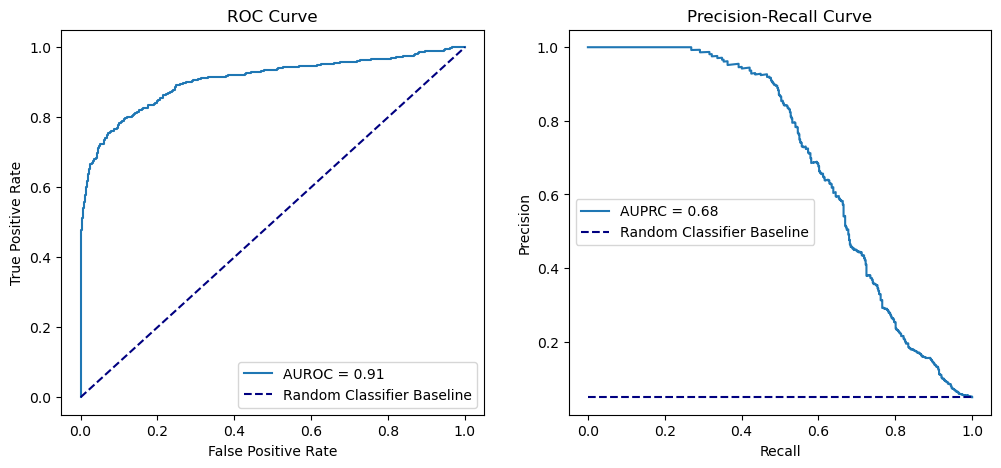

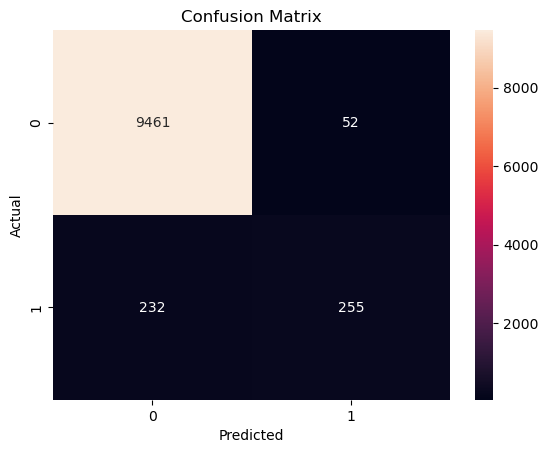

AUROC: 0.9056846666757324, AUPRC: 0.6836778534387796, Max F1 Score: 0.6440251572327045, Best Threshold: 0.10381226962922206


In [11]:
# Get SHAP scores for GRN
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, shap_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")

# Shap with correlation pruning!


In [16]:
def correlation_pruning_with_shap(shap_scores, expression_data, threshold):
    pruned_scores = np.zeros_like(shap_scores)
    for tf in range(shap_scores.shape[0]):  # Iterate over all TFs
        for tg in range(shap_scores.shape[1]):  # Iterate over all TGs
            correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg + 100])  # Adjust index for TGs
            if abs(correlation) > threshold:
                pruned_scores[tf, tg] = shap_scores[tf, tg]
    return pruned_scores


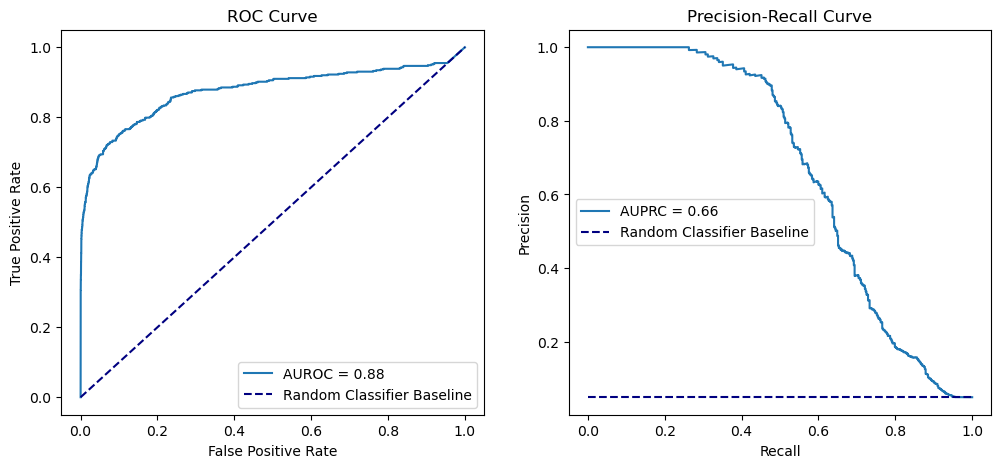

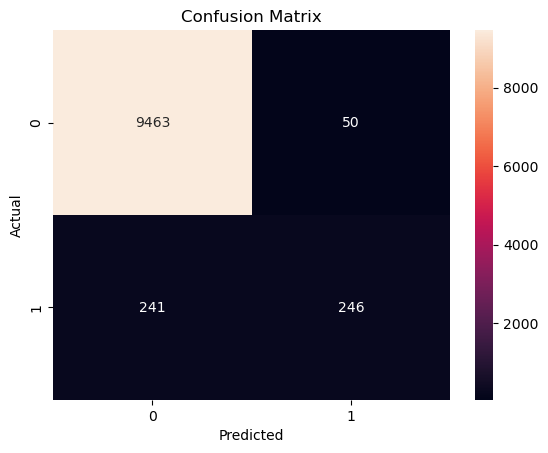

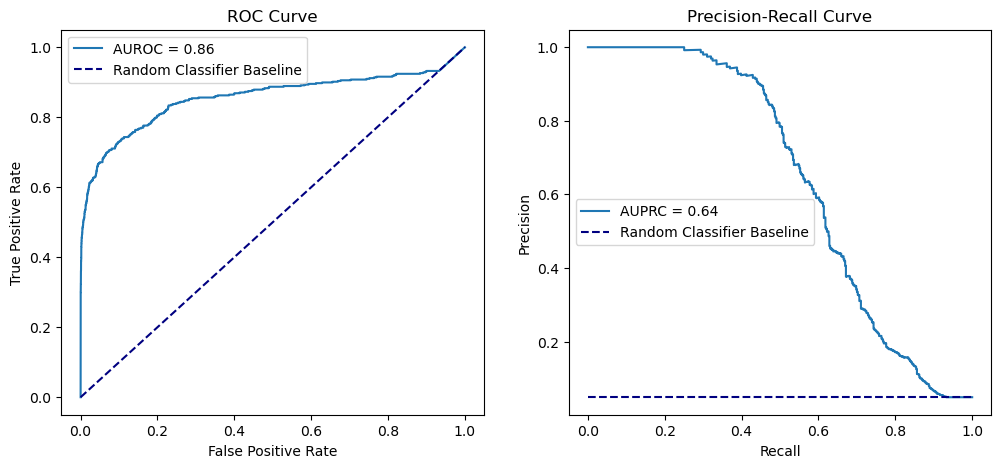

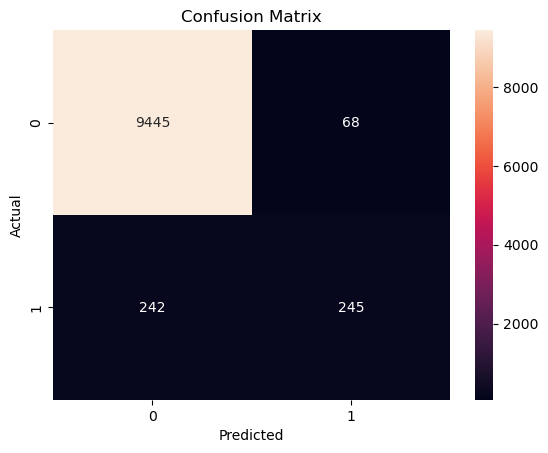

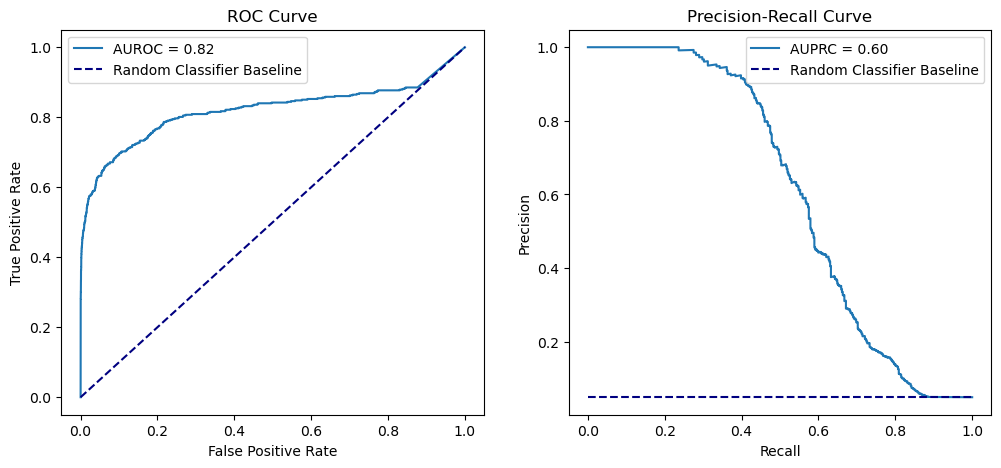

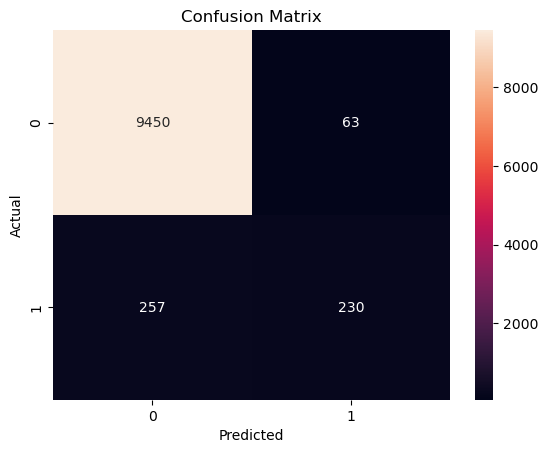

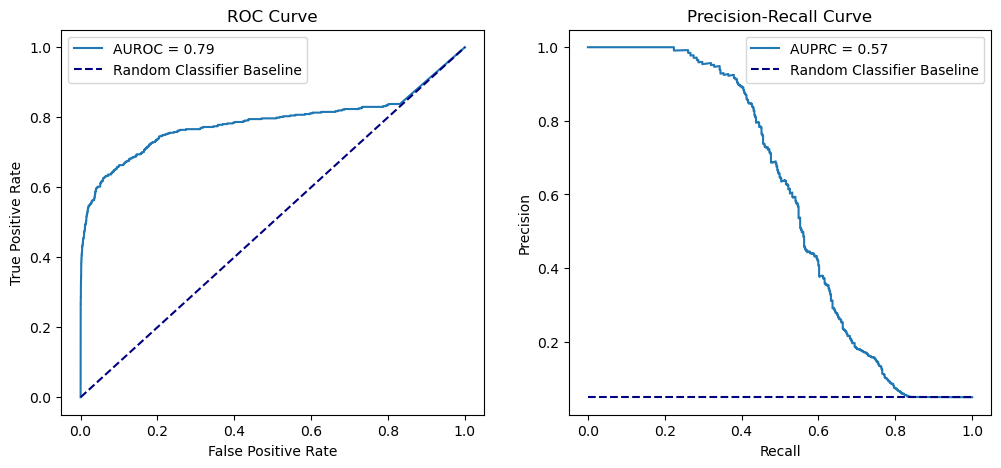

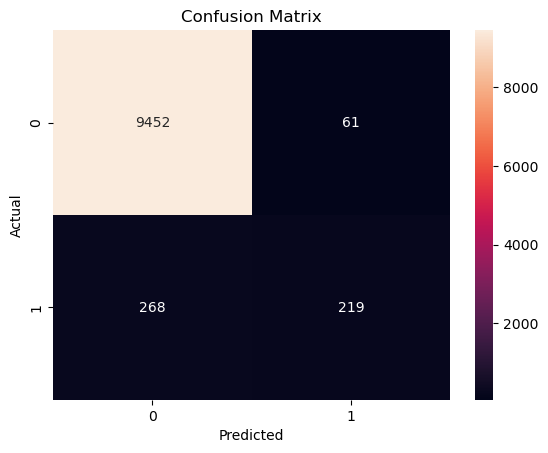

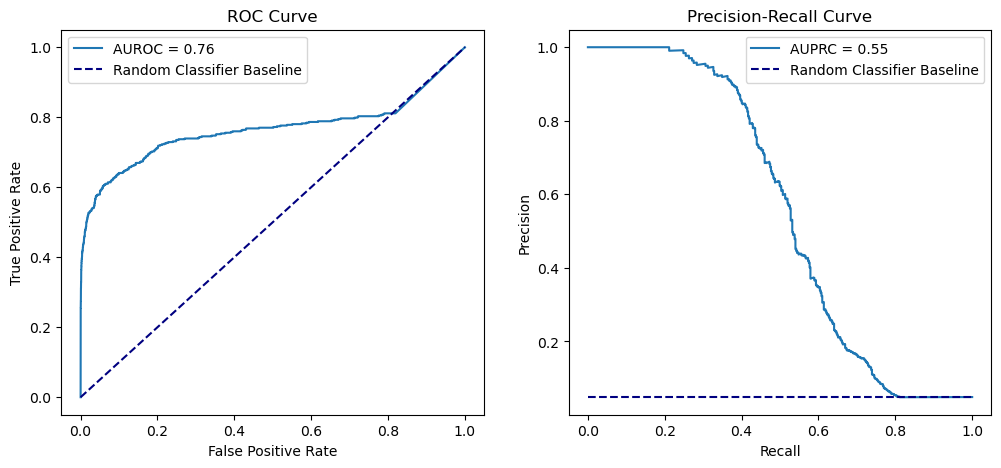

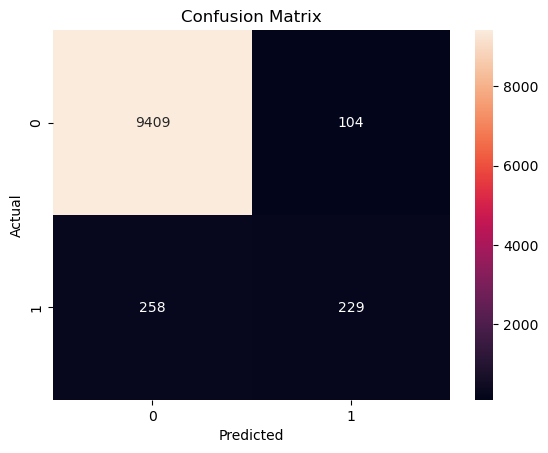

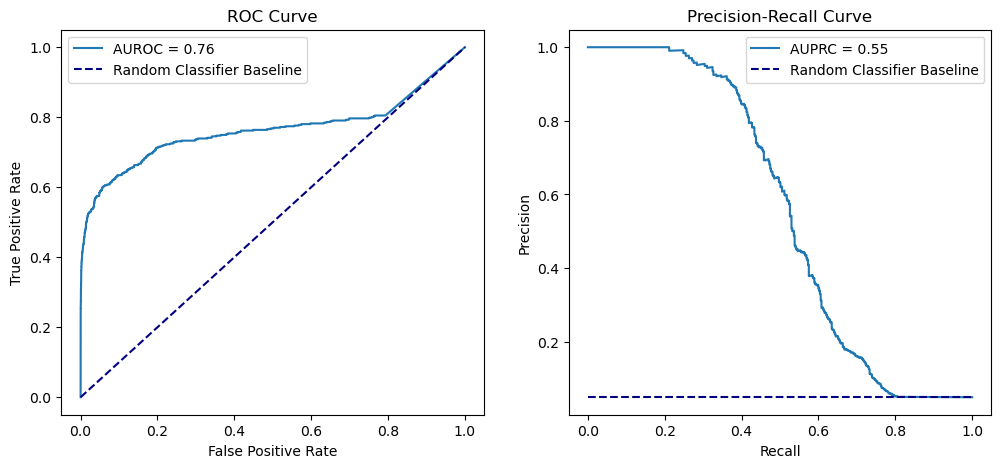

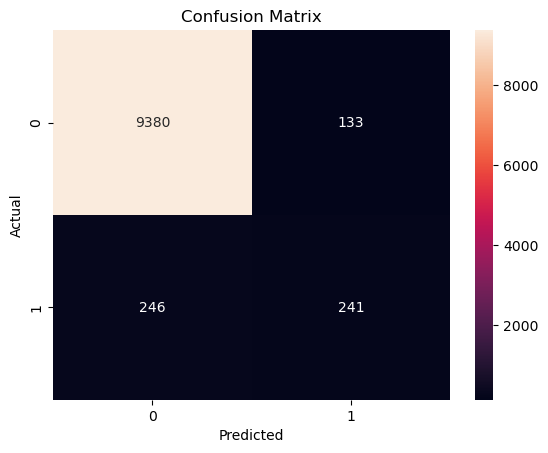

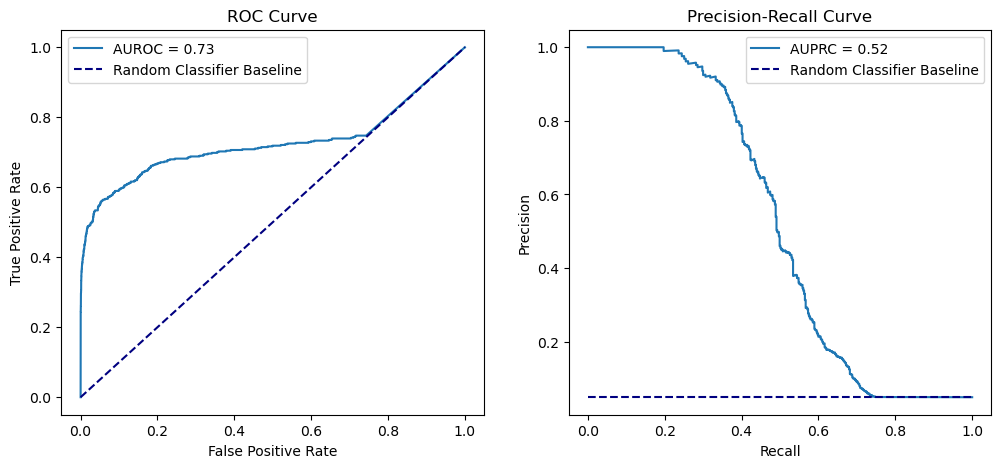

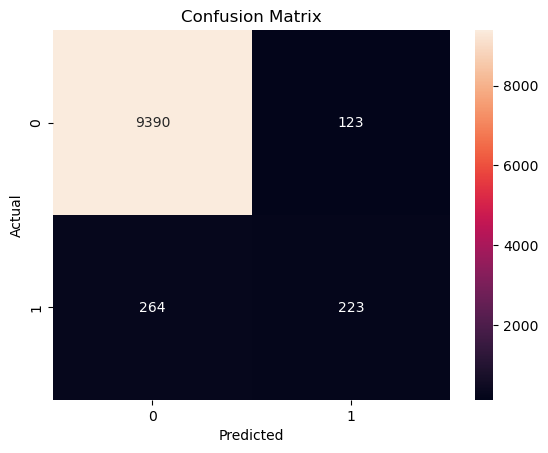

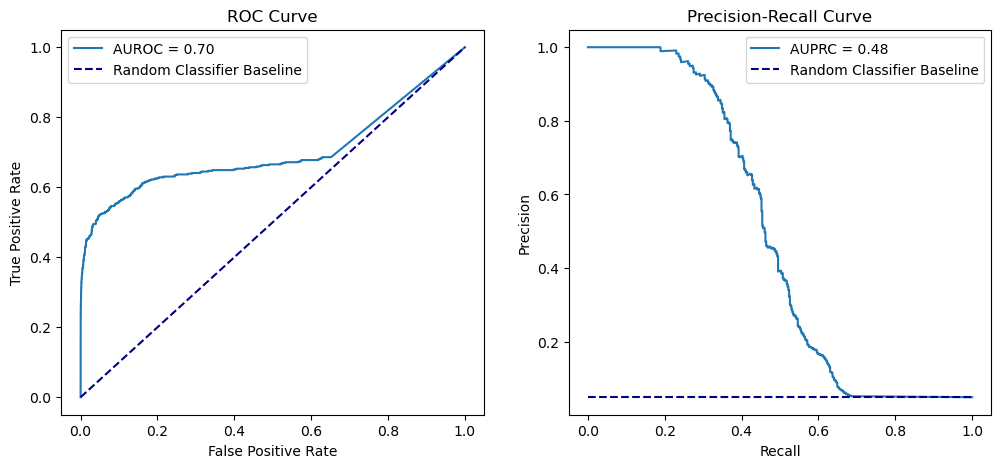

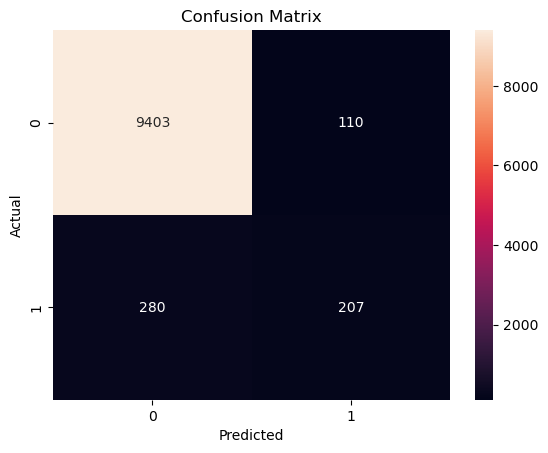

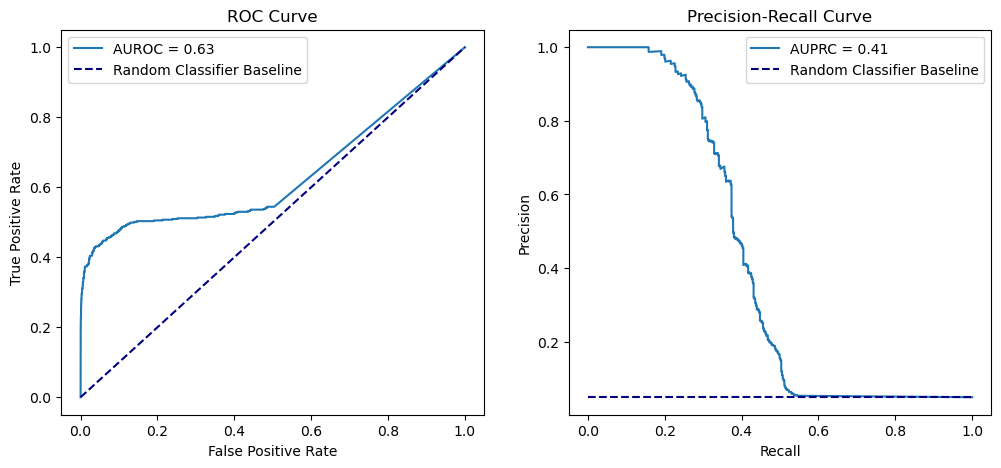

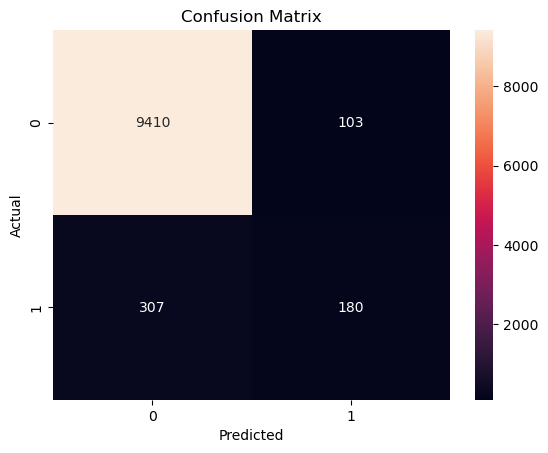

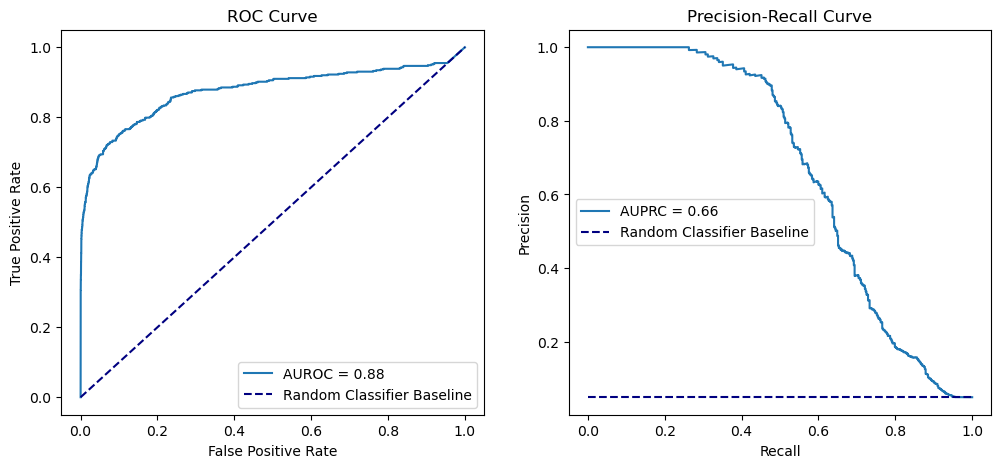

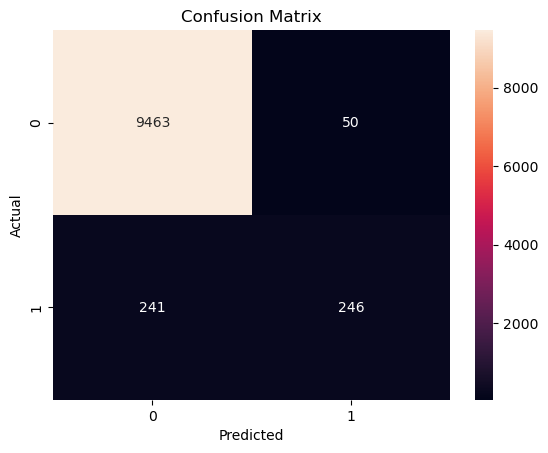

Best Threshold: 0.1, Best AUROC: 0.8750852340609877
AUROC: 0.8750852340609877, AUPRC: 0.65747130268939, Max F1 Score: 0.6301020408163266


In [17]:
def find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds):
    best_auc = 0
    best_threshold = 0
    best_pruned_scores = None

    for threshold in correlation_thresholds:
        pruned_scores = correlation_pruning_with_shap(shap_scores, expression_data, threshold)
        auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, pruned_scores, ground_truth_file)
        
        if auroc > best_auc:  # Update the best threshold based on AUROC or other criteria
            best_auc = auroc
            best_threshold = threshold
            best_pruned_scores = pruned_scores

    return best_threshold, best_pruned_scores, best_auc

# Get SHAP scores from the GRN models
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Find the best threshold with pruning
correlation_thresholds = np.linspace(0.1, 0.9, 9)  # Example range of thresholds
best_threshold, best_pruned_scores, best_auc = find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds)

# Evaluate and display metrics for the best threshold
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, best_pruned_scores, ground_truth_file)
print(f"Best Threshold: {best_threshold}, Best AUROC: {best_auc}")
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")
